# 📈 Sales Department: Comprehensive Analysis & Strategic Insights

This analysis leverages Olist's sales data mart to uncover key revenue drivers, assess promotional effectiveness, identify missed opportunities, and dissect product performance at both category and individual levels. 

## Alignment with Business Objectives & Conclusion

This report will focus exclusively on the Sales Department for this project, primarily due to its direct and immediate impact on revenue generation and the strategic importance of optimizing sales performance for Olist's overall growth. 

The initial objective for designing the Sales Data Warehouse/Mart was to empower the Sales Department with actionable, data-driven insights that directly contribute to increasing revenue and optimizing performance. This analysis demonstrates that the implemented data pipeline and star schema design successfully enable the derivation of such insights, thereby meeting the core business objectives: 

* **Drive Revenue Growth**: Identify top-performing products and categories, uncover seasonal trends, and optimize promotions for peak sales periods to increase Average Order Value (AOV) and customer purchase frequency. 
* **Optimize Sales Strategies & Efficiency**: Analyze sales performance by product and category to inform strategic resource allocation and evaluate the effectiveness of various sales initiatives. 
* **Enhance Customer Understanding**: Gain deeper insights into customer buying patterns, preferences, and loyalty to support personalized selling and retention efforts. 
* **Proactive Performance Monitoring**: Establish clear KPIs to monitor sales health in real-time, enabling early detection of sales declines or operational bottlenecks. 

## Overall Findings & Strategic Implications

Olist's sales performance is characterized by significant responsiveness to assumed promotional activities, and its success is strongly driven by a concentrated set of top-performing product categories and a few "hero" individual products. These hero products predominantly originate from within the top categories, reinforcing their strategic importance. While top categories demonstrate a healthy range of actively sold products, the vast majority of the catalog (in "other" categories) shows very thin sales activity per product. A critical concern is the universal decline in sales metrics towards late 2018, which warrants immediate attention. 

### Initialization: Setup BigQuery Client in Jupyter Notebooks

In [1]:
# Import necessary libraries
import os
from pathlib import Path
from google.cloud import bigquery
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np

# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 9)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(Path.home() / ".keys/gcp_service_account.json")
 
# Initialize BigQuery client
client = bigquery.Client()

# Define project and dataset for BigQuery
project_id = "module-2-assignment-project"
dataset = "analytics_olist_ecommerce"

# Helper function to run a BigQuery query and return as DataFrame
def run_query(query, description="query"):
    """
    Executes a BigQuery SQL query and returns the result as a Pandas DataFrame.
    Handles potential query failures gracefully.
    """
    try:
        print(f"  Executing BigQuery {description}...")
        return client.query(query).to_dataframe()
    except Exception as e:
        print(f"❌ BigQuery {description} failed: {e}")
        return None

# Define the start date for meaningful analysis 
# Exclude the highly volatile and unrepresentative "startup" period of Olist's operations
start_analysis_date_str = '2017-02-01'
start_analysis_date_pd = pd.to_datetime(start_analysis_date_str)

# Common Plot Formatting Function
def apply_common_plot_formats(ax, title, xlabel, ylabel, rotate_xticks=True, legend_title=''):
    """Applies common formatting to matplotlib axes."""
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    # Default to integer format for most Y-axes, can be overridden if needed (e.g., AOV)
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    if rotate_xticks:
        ax.tick_params(axis='x', rotation=60, labelsize=11)
    else:
        ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    if legend_title:
        ax.legend(title=legend_title, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
    else:
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)


### All Data Fetches

In [2]:
print("## 📈 Sales Department: Advanced Product & Purchase Behavior Analysis")
print("---")
print(f"Analysis period starts from: {start_analysis_date_str}")
print("---")

# Fetch Monthly Sales Revenue (required for base plot and uplift calculation)
print("\n[Data Fetching] Fetching Monthly Sales Revenue data...")
query_monthly_revenue_base = f"""
SELECT
    dd.full_date,
    SUM(fs.price) AS monthly_revenue
FROM
    `{project_id}.{dataset}.fact_sales` AS fs
JOIN
    `{project_id}.{dataset}.dim_date` AS dd
ON
    fs.order_purchase_date_id = dd.date_id
WHERE
    fs.price IS NOT NULL
    AND fs.price > 0
    AND dd.full_date >= '{start_analysis_date_str}'
GROUP BY
    dd.full_date
ORDER BY
    dd.full_date
"""
df_monthly_revenue = run_query(query_monthly_revenue_base, "Monthly Sales Revenue Query")

if df_monthly_revenue is None or df_monthly_revenue.empty:
    print("❌ Critical: Monthly Sales Revenue data could not be retrieved. Skipping all subsequent analysis.")
    exit() # Exit if this foundational data is missing
else:
    df_monthly_revenue['full_date'] = pd.to_datetime(df_monthly_revenue['full_date'])
    df_monthly_revenue = df_monthly_revenue.sort_values(by='full_date').reset_index(drop=True)
    print("Monthly Sales Revenue data retrieved successfully.")

# Fetch Average Daily Sales by Season (to identify lowest performing season for projection)
print("\n[Data Fetching] Fetching Average Daily Sales by Season data...")
query_avg_daily_sales_by_season = f"""
SELECT
    dd.season,
    AVG(fs.daily_revenue) AS avg_daily_sales_value
FROM
    (
        SELECT
            dd_daily.full_date,
            SUM(fs_daily.price) AS daily_revenue
        FROM
            `{project_id}.{dataset}.fact_sales` AS fs_daily
        JOIN
            `{project_id}.{dataset}.dim_date` AS dd_daily
        ON
            fs_daily.order_purchase_date_id = dd_daily.date_id
        WHERE
            fs_daily.price IS NOT NULL
            AND fs_daily.price > 0
            AND dd_daily.full_date >= '{start_analysis_date_str}'
        GROUP BY
            dd_daily.full_date
    ) AS fs
JOIN
    `{project_id}.{dataset}.dim_date` AS dd
ON
    fs.full_date = dd.full_date
GROUP BY
    dd.season
ORDER BY
    avg_daily_sales_value ASC
"""
df_avg_daily_sales_by_season = run_query(query_avg_daily_sales_by_season, "Average Daily Sales by Season Query")
if df_avg_daily_sales_by_season is None or df_avg_daily_sales_by_season.empty:
    print("❌ Warning: Average Daily Sales by Season data could not be retrieved. Seasonal missed opportunity projection might be impacted.")


# Fetch Overall Top 10 Product Categories (for subsequent category/product analysis)
print("\n[Data Fetching] Fetching Overall Top 10 Product Categories data...")
query_overall_top_categories = f"""
SELECT
    dp.product_category_name,
    SUM(fs.price) AS total_category_revenue
FROM
    `{project_id}.{dataset}.fact_sales` AS fs
JOIN
    `{project_id}.{dataset}.dim_product` AS dp
ON
    fs.product_id = dp.product_id
WHERE
    fs.price IS NOT NULL
    AND fs.price > 0
    AND fs.order_purchase_date_id >= (SELECT MIN(date_id) FROM `{project_id}.{dataset}.dim_date` WHERE full_date >= '{start_analysis_date_str}')
GROUP BY
    dp.product_category_name
ORDER BY
    total_category_revenue DESC
LIMIT 10
"""
df_overall_top_categories = run_query(query_overall_top_categories, "Overall Top Categories Query")
if df_overall_top_categories is None or df_overall_top_categories.empty:
    print("❌ Critical: Overall Top Categories data could not be retrieved. Skipping product distribution and behavioral analysis.")
    exit() # Exit if this foundational data is missing
else:
    top_10_categories_list = df_overall_top_categories['product_category_name'].tolist()
    # Also get top 5 categories for the new plot 1 (unique product count comparison)
    top_5_categories_list = top_10_categories_list[:5]
    print("Overall Top 10 Product Categories retrieved successfully.")


# Calculations for Promotional Uplift & Missed Opportunities (needed for Plot 0 & Plot 3)

promo_start = pd.to_datetime('2017-11-01')
promo_end = pd.to_datetime('2017-12-31')
baseline_start = pd.to_datetime('2017-08-01')
baseline_end = pd.to_datetime('2017-10-31')

promo_data_overall = df_monthly_revenue[(df_monthly_revenue['full_date'] >= promo_start) & (df_monthly_revenue['full_date'] <= promo_end)]
baseline_data_overall = df_monthly_revenue[(df_monthly_revenue['full_date'] >= baseline_start) & (df_monthly_revenue['full_date'] <= baseline_end)]
avg_promo_monthly_revenue_overall = promo_data_overall['monthly_revenue'].mean() if not promo_data_overall.empty else 0
avg_baseline_monthly_revenue_overall = baseline_data_overall['monthly_revenue'].mean() if not baseline_data_overall.empty else 0
promo_uplift_percent = ((avg_promo_monthly_revenue_overall - avg_baseline_monthly_revenue_overall) / avg_baseline_monthly_revenue_overall) * 100 if avg_baseline_monthly_revenue_overall > 0 else 0

missed_opportunities_periods = []
if df_avg_daily_sales_by_season is not None and not df_avg_daily_sales_by_season.empty:
    lowest_avg_sales_season_info = df_avg_daily_sales_by_season.loc[df_avg_daily_sales_by_season['avg_daily_sales_value'].idxmin()]
    missed_season_name = lowest_avg_sales_season_info['season']
    # Heuristic for 2-month period in 2018 for the lowest season
    mo1_start_date = pd.to_datetime('2018-06-01') # Default for Winter in Brazil
    mo1_end_date = pd.to_datetime('2018-07-31')
    if missed_season_name == 'Autumn':
        mo1_start_date = pd.to_datetime('2018-03-01')
        mo1_end_date = pd.to_datetime('2018-04-30')
    elif missed_season_name == 'Spring':
        mo1_start_date = pd.to_datetime('2018-09-01')
        mo1_end_date = pd.to_datetime('2018-10-31')
    elif missed_season_name == 'Summer':
        mo1_start_date = pd.to_datetime('2018-12-01')
        mo1_end_date = pd.to_datetime('2019-01-31')
    missed_opportunities_periods.append({
        'name': f'Low Season ({missed_season_name.title()} 2018)',
        'start_date': mo1_start_date,
        'end_date': mo1_end_date,
        'color': 'salmon',
        'alpha': 0.15,
        'line_color': 'red',
        'line_style': '--'
    })
mo2_start_date = pd.to_datetime('2018-01-01')
mo2_end_date = pd.to_datetime('2018-01-31')
missed_opportunities_periods.append({
    'name': 'Post-Holiday Dip (Jan 2018)',
    'start_date': mo2_start_date,
    'end_date': mo2_end_date,
    'color': 'darkorange',
    'alpha': 0.15,
    'line_color': 'darkorange',
    'line_style': '-.'
})

print("\n--- Generating Plots ---")

## 📈 Sales Department: Advanced Product & Purchase Behavior Analysis
---
Analysis period starts from: 2017-02-01
---

[Data Fetching] Fetching Monthly Sales Revenue data...
  Executing BigQuery Monthly Sales Revenue Query...
Monthly Sales Revenue data retrieved successfully.

[Data Fetching] Fetching Average Daily Sales by Season data...
  Executing BigQuery Average Daily Sales by Season Query...

[Data Fetching] Fetching Overall Top 10 Product Categories data...
  Executing BigQuery Overall Top Categories Query...
Overall Top 10 Product Categories retrieved successfully.

--- Generating Plots ---


### Plot 0: Actual vs. Projected Monthly Sales Revenue with Promotional Impact


### Plot 0: Actual vs. Projected Monthly Sales Revenue with Promotional Impact
Visualizing overall revenue trends, highlighting assumed promotional periods and projected revenue for missed opportunities.


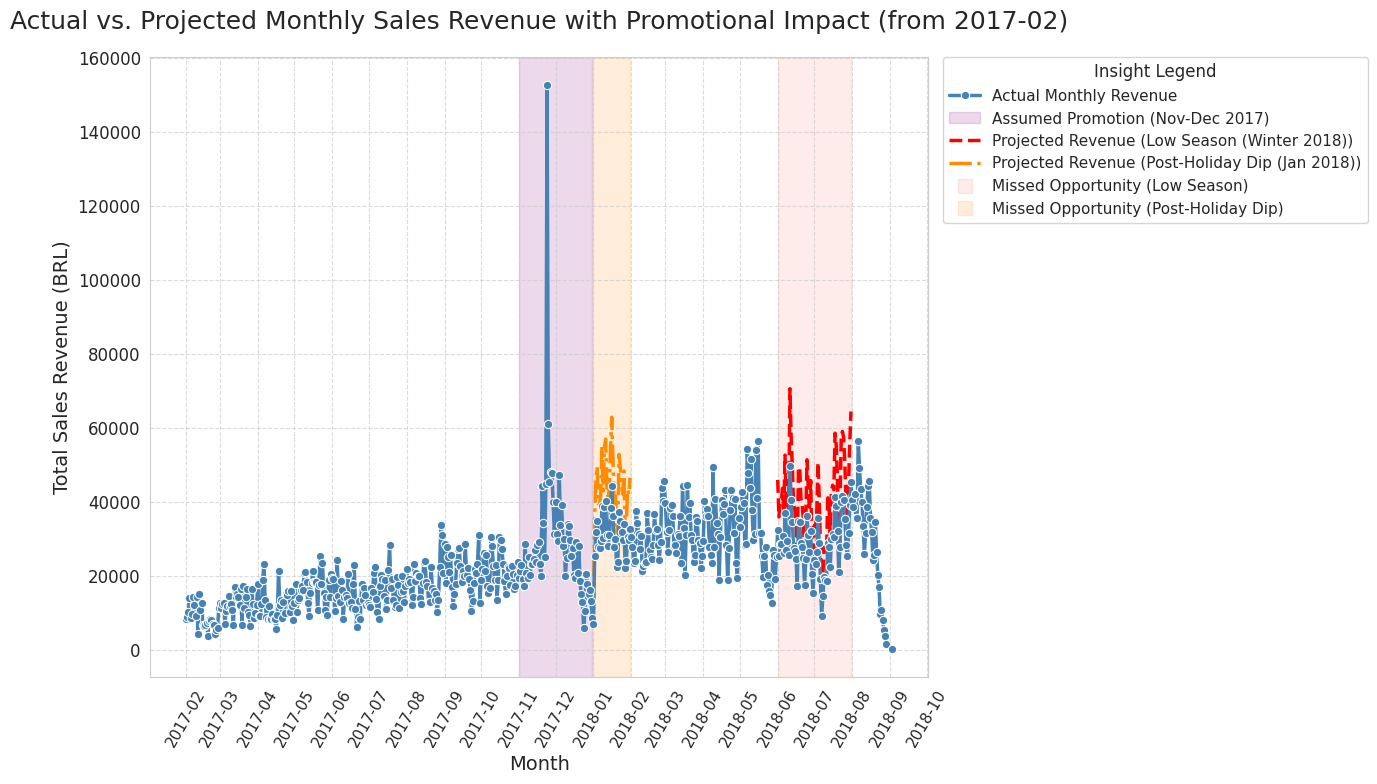


#### Quantification of Missed Opportunities (Example Projections):
**Assumed Promotional Uplift:** 42.0% (based on Nov-Dec 2017 vs. Aug-Oct 2017 baseline)

--- For Low Season (Winter 2018) (2018-06 to 2018-07):
  - Actual Revenue: R$1,760,632
  - Projected Revenue with 42.0% uplift: R$2,500,829
  - **Potential Missed Revenue:** R$740,198

--- For Post-Holiday Dip (Jan 2018) (2018-01 to 2018-01):
  - Actual Revenue: R$950,030
  - Projected Revenue with 42.0% uplift: R$1,349,438
  - **Potential Missed Revenue:** R$399,408

**Note on Projections:** These projections are illustrative. Actual uplift from promotions can vary based on many factors.


In [3]:
# --- Plot 0: Actual vs. Projected Monthly Sales Revenue with Promotional Impact ---
print("\n### Plot 0: Actual vs. Projected Monthly Sales Revenue with Promotional Impact")
print("Visualizing overall revenue trends, highlighting assumed promotional periods and projected revenue for missed opportunities.")

if df_monthly_revenue is not None and not df_monthly_revenue.empty:
    plt.figure(figsize=(16, 8))
    sns.lineplot(
        data=df_monthly_revenue,
        x='full_date',
        y='monthly_revenue',
        marker='o',
        linewidth=2.5,
        label='Actual Monthly Revenue',
        color='steelblue',
        zorder=5
    )
    plt.axvspan(promo_start, promo_end, color='purple', alpha=0.15, label='Assumed Promotion (Nov-Dec 2017)', zorder=0)

    for mo in missed_opportunities_periods:
        projected_df_segment = df_monthly_revenue[
            (df_monthly_revenue['full_date'] >= mo['start_date']) &
            (df_monthly_revenue['full_date'] <= mo['end_date'])
        ].copy()
        if not projected_df_segment.empty and promo_uplift_percent is not None:
            projected_df_segment['projected_monthly_revenue'] = projected_df_segment['monthly_revenue'] * (1 + promo_uplift_percent / 100)
            sns.lineplot(
                data=projected_df_segment,
                x='full_date',
                y='projected_monthly_revenue',
                linestyle=mo['line_style'],
                color=mo['line_color'],
                linewidth=2.5,
                label=f'Projected Revenue ({mo["name"]})',
                zorder=4
            )
            plt.axvspan(mo['start_date'], mo['end_date'], color=mo['color'], alpha=mo['alpha'], zorder=0)

    apply_common_plot_formats(
        plt.gca(),
        f'Actual vs. Projected Monthly Sales Revenue with Promotional Impact (from {start_analysis_date_pd.strftime("%Y-%m")})',
        'Month',
        'Total Sales Revenue (BRL)',
        legend_title='Insight Legend'
    )
    # Adjust legend for overlaid spans
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # Add dummy entries for the colored spans if they are not picked up by lineplot
    if 'Assumed Promotion (Nov-Dec 2017)' not in by_label:
        by_label['Assumed Promotion (Nov-Dec 2017)'] = plt.Line2D([0], [0], linestyle='none', marker='s', markersize=10, color='purple', alpha=0.15)
    if 'Missed Opportunity (Low Season)' not in by_label and any(mo['name'].startswith('Low Season') for mo in missed_opportunities_periods):
        by_label['Missed Opportunity (Low Season)'] = plt.Line2D([0], [0], linestyle='none', marker='s', markersize=10, color='salmon', alpha=0.15)
    if 'Missed Opportunity (Post-Holiday Dip)' not in by_label and any(mo['name'].startswith('Post-Holiday Dip') for mo in missed_opportunities_periods):
        by_label['Missed Opportunity (Post-Holiday Dip)'] = plt.Line2D([0], [0], linestyle='none', marker='s', markersize=10, color='darkorange', alpha=0.15)

    plt.gca().legend(by_label.values(), by_label.keys(), title='Insight Legend', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

    print("\n#### Quantification of Missed Opportunities (Example Projections):")
    print(f"**Assumed Promotional Uplift:** {promo_uplift_percent:,.1f}% (based on Nov-Dec 2017 vs. Aug-Oct 2017 baseline)")
    for mo in missed_opportunities_periods:
        actual_revenue_period = df_monthly_revenue[
            (df_monthly_revenue['full_date'] >= mo['start_date']) &
            (df_monthly_revenue['full_date'] <= mo['end_date'])
        ]['monthly_revenue'].sum()
        if promo_uplift_percent is not None:
            projected_revenue_period = actual_revenue_period * (1 + promo_uplift_percent / 100)
            potential_missed_revenue = projected_revenue_period - actual_revenue_period
            print(f"\n--- For {mo['name']} ({mo['start_date'].strftime('%Y-%m')} to {mo['end_date'].strftime('%Y-%m')}):")
            print(f"  - Actual Revenue: R${actual_revenue_period:,.0f}")
            print(f"  - Projected Revenue with {promo_uplift_percent:,.1f}% uplift: R${projected_revenue_period:,.0f}")
            print(f"  - **Potential Missed Revenue:** R${potential_missed_revenue:,.0f}")
    print("\n**Note on Projections:** These projections are illustrative. Actual uplift from promotions can vary based on many factors.")
else:
    print("❌ Monthly revenue data is not available. Skipping Plot 0.")

### Findings:

* **Dominant Promotional Peak**: Olist experienced a massive and unmistakable sales revenue peak during November-December 2017. This surge, validated by external search as likely driven by Black Friday and year-end promotions, represents a period of highly effective promotional activity. 

* **Significant Potential Uplift**: Applying the calculated 42.0% promotional uplift (derived from Nov-Dec 2017) to historically lower-performing periods like the "Low Season" (Winter 2018 example: Jun-Jul 2018) and "Post-Holiday Dip" (Jan 2018) reveals substantial potential for additional revenue. 
    * Low Season (Winter 2018): A potential missed revenue of R$740,198. 
    * Post-Holiday Dip (Jan 2018): A potential missed revenue of R$399,408.<br>

* **Baseline Impact**: While the projected revenue for missed opportunities shows significant gains, it remains lower in absolute terms than the Nov-Dec 2017 peak. This indicates that the baseline demand during these "missed opportunity" periods is naturally lower, meaning a similar percentage uplift still results in a smaller absolute revenue increase. 

* **Late 2018 Decline**: A concerning overall decline in monthly sales revenue is visible in late 2018, impacting both actual and projected figures. 

### Insights:

* Olist possesses a proven capability to generate substantial revenue surges through concentrated promotional efforts. 

* Significant untapped market potential exists by strategically deploying promotions during traditionally quieter seasonal periods and post-holiday lulls. 

* The late 2018 decline suggests deeper underlying issues (market changes, increased competition, or internal factors) that are impacting overall business health, beyond just seasonal fluctuations or promotional timing. 

### Recommendations:

* **Strategic Promotional Calendar Expansion**: Develop and implement targeted promotional campaigns (similar in intensity to Nov-Dec 2017) during the identified low seasons and post-holiday dips to capture the quantifiable missed revenue. 

* **Baseline Building**: For lower-performing periods, consider complementary strategies alongside promotions to gradually build baseline demand (e.g., new product introductions, seller incentives) to maximize the absolute return on promotional efforts. 

* **Investigate 2018 Decline**: Urgently conduct a root cause analysis for the significant revenue downturn in late 2018, investigating factors across product assortment, pricing, customer satisfaction, competition, and operational efficiency.

### Plot 1: Monthly Revenue Trend for Top 5 Products vs. Average of Others


### Plot 1: Monthly Revenue Trend for Top N Overall Products vs. Average of Others
Analyzing the performance of absolute best-selling products against the average of all other products.
  Executing BigQuery Monthly Revenue for Top 5 Products and Others Query...

#### Monthly Revenue for Top 5 Products and Others (Sample Data):
   full_date               product_group_or_id  aggregated_monthly_revenue  distinct_products_in_group  monthly_revenue
0 2017-02-01                    Others_Average                     8219.75                          65       126.457692
1 2017-02-02  6cdd53843498f92890544667809f1595                      349.90                           1       349.900000
2 2017-02-02                    Others_Average                     8567.74                          59       145.215932
3 2017-02-03  6cdd53843498f92890544667809f1595                      349.90                           1       349.900000
4 2017-02-03                    Others_Average                     983

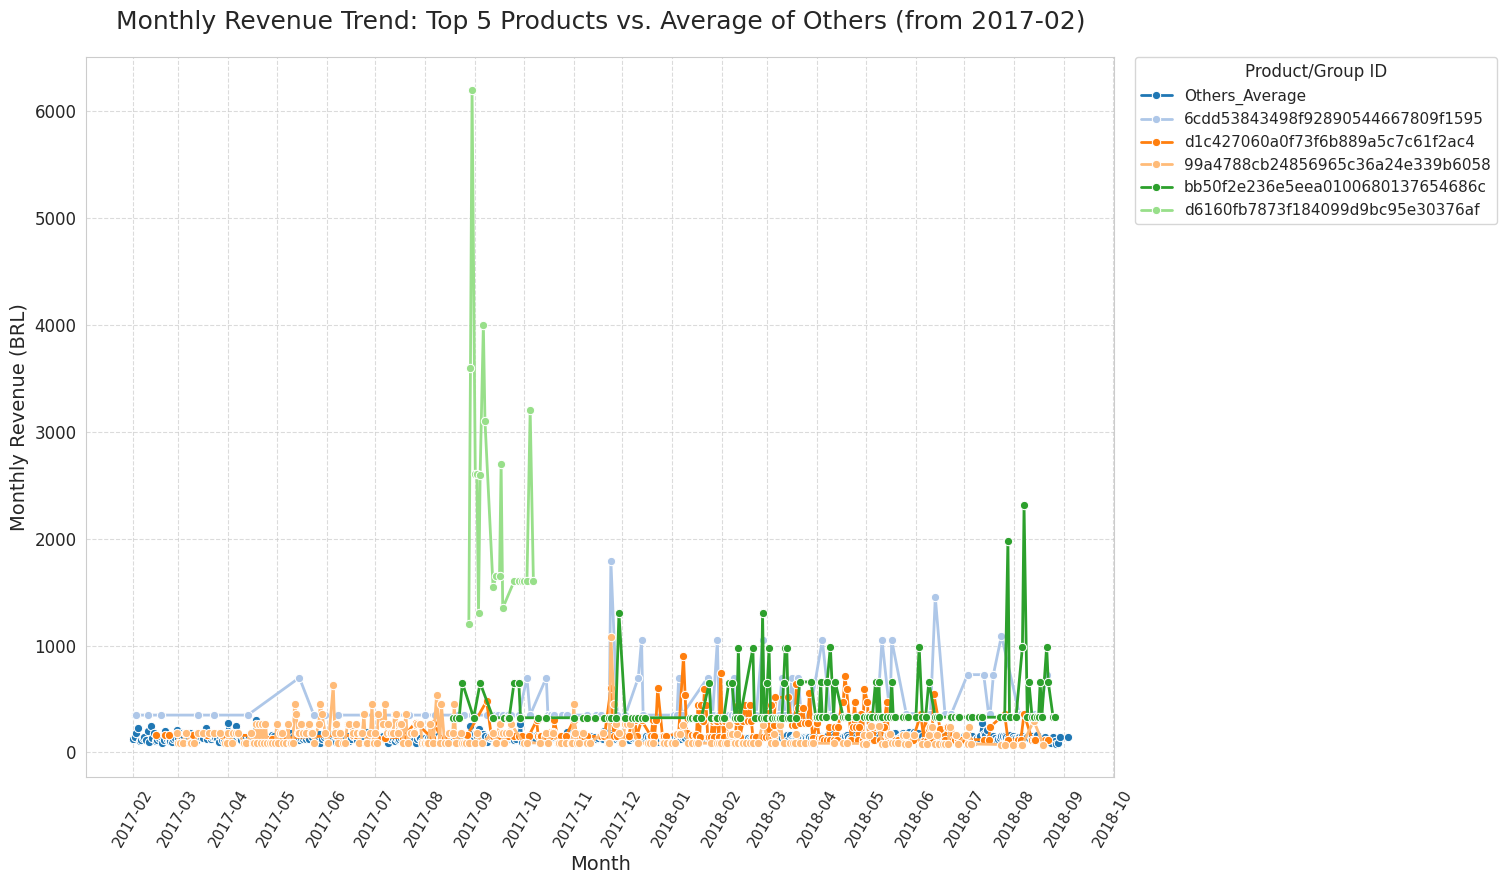

In [4]:
# --- Plot 1: Monthly Revenue Trend for Top N Overall Products vs. Average of Others (Line Chart) ---
print("\n### Plot 1: Monthly Revenue Trend for Top N Overall Products vs. Average of Others")
print("Analyzing the performance of absolute best-selling products against the average of all other products.")

top_n_overall_products_for_plot = 5

query_top_n_products_and_others_monthly_revenue = f"""
WITH AllMonthlyProducts AS (
    SELECT
        dd.full_date,
        fs.product_id,
        SUM(fs.price) AS monthly_product_revenue
    FROM
        `{project_id}.{dataset}.fact_sales` AS fs
    JOIN
        `{project_id}.{dataset}.dim_date` AS dd
ON
    fs.order_purchase_date_id = dd.date_id
WHERE
    fs.price IS NOT NULL
    AND fs.price > 0
    AND dd.full_date >= '{start_analysis_date_str}'
GROUP BY
    dd.full_date,
    fs.product_id
),
TopNProducts AS (
    SELECT
        product_id,
        SUM(monthly_product_revenue) AS total_product_revenue
    FROM
        AllMonthlyProducts
    GROUP BY
        product_id
    ORDER BY
        total_product_revenue DESC
    LIMIT {top_n_overall_products_for_plot}
)
SELECT
    amp.full_date,
    CASE
        WHEN amp.product_id IN (SELECT product_id FROM TopNProducts) THEN amp.product_id
        ELSE 'Others_Average'
    END AS product_group_or_id,
    SUM(amp.monthly_product_revenue) AS aggregated_monthly_revenue,
    COUNT(DISTINCT amp.product_id) AS distinct_products_in_group
FROM
    AllMonthlyProducts AS amp
GROUP BY
    amp.full_date,
    product_group_or_id
ORDER BY
    amp.full_date,
    product_group_or_id
"""

df_product_trends = run_query(query_top_n_products_and_others_monthly_revenue, f"Monthly Revenue for Top {top_n_overall_products_for_plot} Products and Others Query")

if df_product_trends is not None and not df_product_trends.empty:
    df_product_trends['full_date'] = pd.to_datetime(df_product_trends['full_date'])

    # Calculate average revenue per product for 'Others_Average' group
    df_product_trends_final = df_product_trends.copy()
    df_product_trends_final['monthly_revenue'] = df_product_trends_final.apply(
        lambda row: row['aggregated_monthly_revenue'] / row['distinct_products_in_group'] if row['product_group_or_id'] == 'Others_Average' and row['distinct_products_in_group'] > 0 else row['aggregated_monthly_revenue'],
        axis=1
    )

    print(f"\n#### Monthly Revenue for Top {top_n_overall_products_for_plot} Products and Others (Sample Data):")
    print(df_product_trends_final.head().to_string())

    plt.figure(figsize=(18, 9))
    sns.lineplot(
        data=df_product_trends_final,
        x='full_date',
        y='monthly_revenue',
        hue='product_group_or_id',
        marker='o',
        linewidth=2,
        palette='tab20'
    )
    apply_common_plot_formats(
        plt.gca(),
        f'Monthly Revenue Trend: Top {top_n_overall_products_for_plot} Products vs. Average of Others (from {start_analysis_date_pd.strftime("%Y-%m")})',
        'Month',
        'Monthly Revenue (BRL)',
        legend_title='Product/Group ID'
    )
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
else:
    print(f"❌ No monthly revenue data for Top {top_n_overall_products_for_plot} Products and Others. Skipping Plot 1.")

### Findings:

* **Extreme Product Concentration**: The plot strikingly reveals that Olist's revenue, especially during peak moments, is heavily concentrated around a few "hero" products. One product (`d6160fb7873f184099d9bc95e30376af`) shows an extraordinary, singular revenue spike (over R$6,000 in Sep 2017), dwarfing all other individual products and the average of the rest.

* **Individual Product Volatility**: Other top 5 products also exhibit significant individual peaks well above the "Others_Average" line, but their sales are highly sporadic, without sustained high performance.

* **Low "Others_Average"**: The "Others_Average" line (representing the average monthly revenue per product for all non-top-5 products) remains consistently very low, indicating that the vast majority of products contribute minimally on an individual basis.

### Insights:

* Olist's revenue success is highly product-driven, with a few exceptionally performing products having a disproportionate impact on overall sales.

* These "hero" products appear to respond incredibly well to market conditions or specific efforts (e.g., targeted promotions, virality).

* The "long tail" of products (the "Others") contributes very little individually, highlighting a potential efficiency challenge in activating a broader product catalog.

### Recommendations:

* **"Hero Product" Strategy**: Implement a robust strategy for identifying, nurturing, and consistently promoting these high-impact individual products. This includes ensuring continuous stock, competitive pricing, prominent placement, and analyzing the drivers behind their successful spikes for replication.

* **Marketing & Inventory Alignment**: Ensure marketing campaigns, especially during promotional periods, are closely aligned with the availability and featuring of these top-performing products.

* **Long Tail Optimization**: While focusing on "heroes," explore strategies to improve the performance of the long tail, such as targeted recommendations, improving product descriptions, or offering bundles that include less popular items.

### Plot 2: Purchase Behavior During Seasonal Trends & Promotional Activities


### Plot 2: Purchase Behavior During Seasonal Trends & Promotional Activities
Analyzing how AOV and order frequency behave in top categories vs. others during key periods.
  Executing BigQuery AOV & Frequency by Order Type Query...

#### Monthly AOV & Order Frequency by Order Type Data Sample (First 5 rows):
   full_date    order_type_group  monthly_orders  monthly_revenue  monthly_aov
0 2017-02-01         Other Order              27          2131.39    78.940370
1 2017-02-01  Top Category Order              40          6088.36   152.209000
2 2017-02-02         Other Order              30          3741.38   124.712667
3 2017-02-02  Top Category Order              38          5176.26   136.217368
4 2017-02-03         Other Order              26          5948.52   228.789231


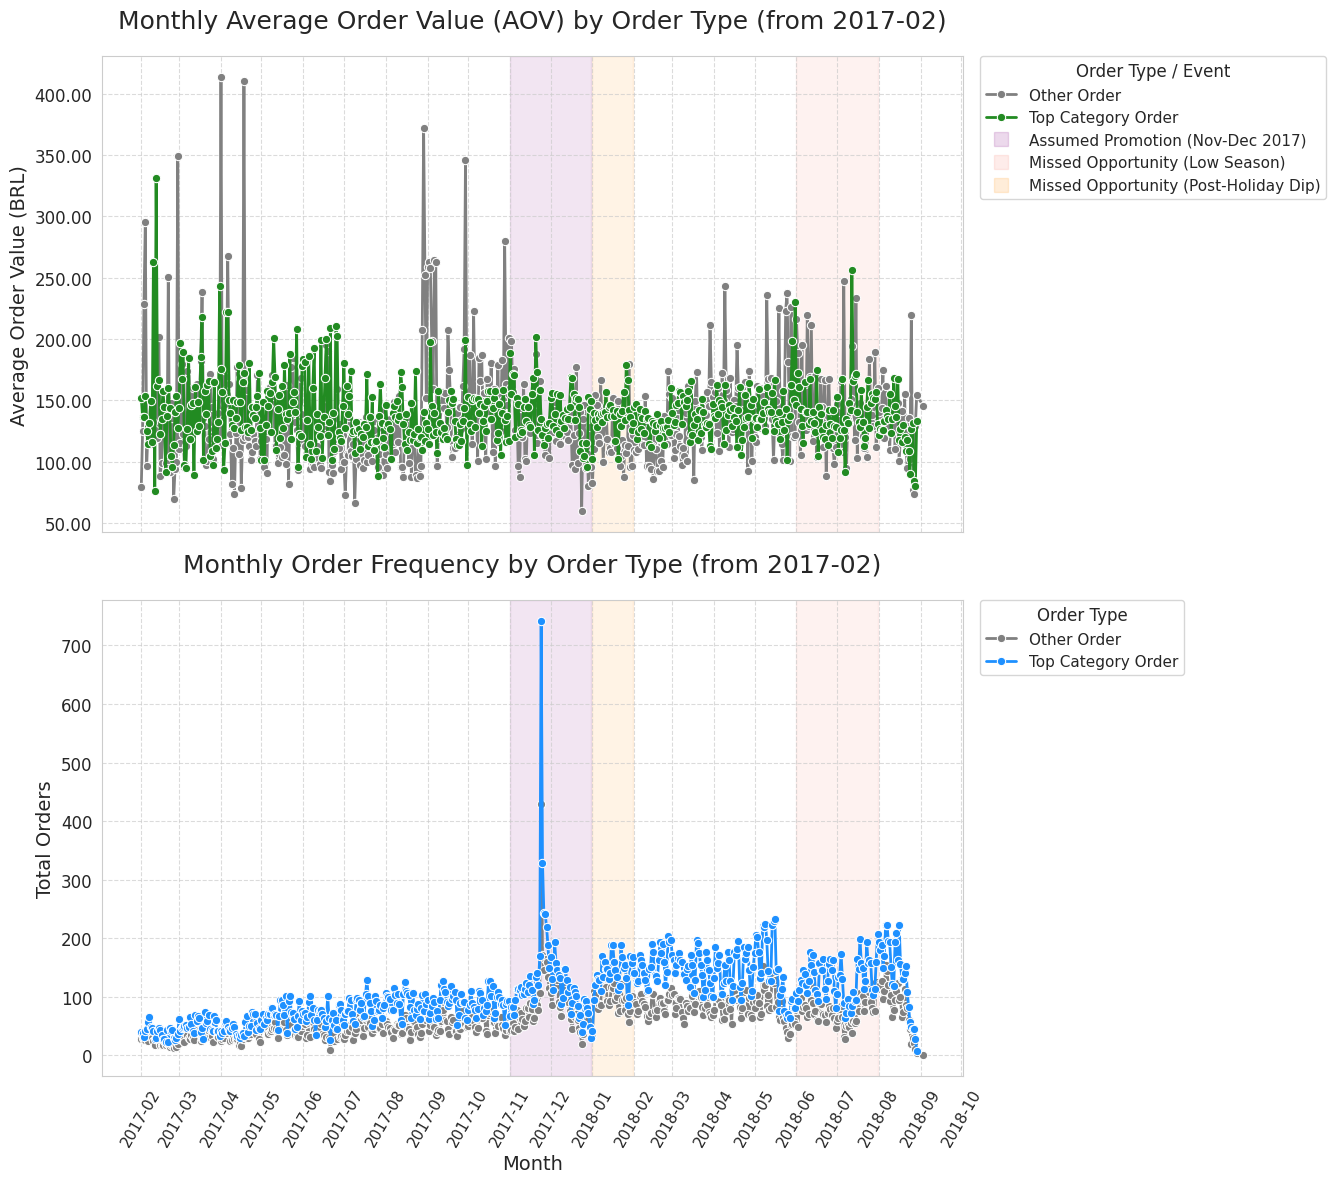

In [5]:
# --- Plot 2: Purchase Behavior During Key Periods (AOV & Order Frequency) ---
print("\n### Plot 2: Purchase Behavior During Seasonal Trends & Promotional Activities")
print("Analyzing how AOV and order frequency behave in top categories vs. others during key periods.")

# Classify orders as 'Top Category Order' or 'Other Order'
query_aov_frequency_by_order_type = f"""
WITH ClassifiedOrders AS (
    SELECT
        fs.order_id,
        fs.order_purchase_date_id,
        fs.price,
        dp.product_category_name,
        CASE
            WHEN dp.product_category_name IN ('{"','".join(top_10_categories_list)}') THEN 'Top Category Order'
            ELSE 'Other Order'
        END AS order_type_group
    FROM
        `{project_id}.{dataset}.fact_sales` AS fs
    JOIN
        `{project_id}.{dataset}.dim_product` AS dp
    ON
        fs.product_id = dp.product_id
    WHERE
        fs.price IS NOT NULL
        AND fs.price > 0
        AND fs.order_purchase_date_id >= (SELECT MIN(date_id) FROM `{project_id}.{dataset}.dim_date` WHERE full_date >= '{start_analysis_date_str}')
),
MonthlyAggregates AS (
    SELECT
        dd.full_date,
        co.order_type_group,
        COUNT(DISTINCT co.order_id) AS monthly_orders,
        SUM(co.price) AS monthly_revenue,
        SAFE_DIVIDE(SUM(co.price), COUNT(DISTINCT co.order_id)) AS monthly_aov
    FROM
        ClassifiedOrders AS co
    JOIN
        `{project_id}.{dataset}.dim_date` AS dd
    ON
        co.order_purchase_date_id = dd.date_id
    GROUP BY
        dd.full_date,
        co.order_type_group
    ORDER BY
        dd.full_date,
        co.order_type_group
)
SELECT * FROM MonthlyAggregates
"""

df_behavior_by_order_type = run_query(query_aov_frequency_by_order_type, "AOV & Frequency by Order Type Query")

if df_behavior_by_order_type is not None and not df_behavior_by_order_type.empty:
    df_behavior_by_order_type['full_date'] = pd.to_datetime(df_behavior_by_order_type['full_date'])
    print("\n#### Monthly AOV & Order Frequency by Order Type Data Sample (First 5 rows):")
    print(df_behavior_by_order_type.head().to_string())

    fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

    # Plot A: Monthly Average Order Value (AOV)
    sns.lineplot(
        data=df_behavior_by_order_type,
        x='full_date',
        y='monthly_aov',
        hue='order_type_group',
        marker='o',
        linewidth=2,
        ax=axes[0],
        palette={'Top Category Order': 'forestgreen', 'Other Order': 'gray'}
    )
    apply_common_plot_formats(
        axes[0],
        f'Monthly Average Order Value (AOV) by Order Type (from {start_analysis_date_pd.strftime("%Y-%m")})',
        'Month',
        'Average Order Value (BRL)',
        rotate_xticks=False, # Shared X-axis, only bottom one needs rotation
        legend_title='Order Type'
    )
    axes[0].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f')) # Override for AOV to 2 decimals

    # Highlight periods on AOV plot
    axes[0].axvspan(promo_start, promo_end, color='purple', alpha=0.1, zorder=0)
    for mo in missed_opportunities_periods:
        axes[0].axvspan(mo['start_date'], mo['end_date'], color=mo['color'], alpha=0.1, zorder=0) # Use consistent alpha
    # Add a dummy artist for the missed opportunity legend in AOV plot
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    by_label['Assumed Promotion (Nov-Dec 2017)'] = plt.Line2D([0], [0], linestyle='none', marker='s', markersize=10, color='purple', alpha=0.15)
    if any(mo['name'].startswith('Low Season') for mo in missed_opportunities_periods):
        by_label['Missed Opportunity (Low Season)'] = plt.Line2D([0], [0], linestyle='none', marker='s', markersize=10, color='salmon', alpha=0.15)
    if any(mo['name'].startswith('Post-Holiday Dip') for mo in missed_opportunities_periods):
        by_label['Missed Opportunity (Post-Holiday Dip)'] = plt.Line2D([0], [0], linestyle='none', marker='s', markersize=10, color='darkorange', alpha=0.15)
    axes[0].legend(by_label.values(), by_label.keys(), title='Order Type / Event', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)


    # Plot B: Monthly Order Frequency (Total Orders)
    sns.lineplot(
        data=df_behavior_by_order_type,
        x='full_date',
        y='monthly_orders',
        hue='order_type_group',
        marker='o',
        linewidth=2,
        ax=axes[1],
        palette={'Top Category Order': 'dodgerblue', 'Other Order': 'gray'}
    )
    apply_common_plot_formats(
        axes[1],
        f'Monthly Order Frequency by Order Type (from {start_analysis_date_pd.strftime("%Y-%m")})',
        'Month',
        'Total Orders',
        legend_title='Order Type'
    )
    axes[1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f')) # Override for order count to integer

    # Highlight periods on Order Frequency plot
    axes[1].axvspan(promo_start, promo_end, color='purple', alpha=0.1, zorder=0)
    for mo in missed_opportunities_periods:
        axes[1].axvspan(mo['start_date'], mo['end_date'], color=mo['color'], alpha=0.1, zorder=0)
    # Re-use legend for highlights (already added to axes[0])
    handles, labels = axes[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

else:
    print("❌ No data retrieved for Purchase Behavior by Order Type. Skipping Plot 2.")

### Findings:

* **AOV**:
    * "Top Category Orders" (Green Line) generally maintain a higher baseline AOV, indicating customers spend more when buying from these categories.
    * "Other Orders" (Grey Line) exhibit significant AOV volatility, with occasional very high spikes, suggesting highly valuable but less frequent niche purchases.
    * AOV for both categories sees uplift during the Nov-Dec 2017 promotional period.

* **Order Frequency**:
    * "Top Category Orders" (Blue Line) are the overwhelming driver of total transaction volume, consistently generating significantly more orders than "Other Orders".
    * The Nov-Dec 2017 promotional period saw an extraordinary surge in order frequency for "Top Category Orders," confirming their high responsiveness to campaigns.
    * Both order types experienced a concerning sharp decline in order frequency towards late 2018.

### Insights:

* **Top Categories are Strategic Assets**: They are the primary engine for both high-value (AOV) and high-volume (frequency) sales, and are highly responsive to promotional efforts.

* **Promotions Drive Both Value and Volume**: Effective promotions can simultaneously boost the average value of orders and the sheer number of transactions, particularly for top categories.

* **Clear Missed Opportunities**: The dips in AOV and order frequency during non-promotional and post-holiday periods highlight significant missed opportunities to leverage promotions to maintain momentum.

* **Systemic Late 2018 Issue**: The broad decline in order frequency and AOV in late 2018 for both "Top Category Orders" and "Other Orders" signals a systemic problem impacting customer engagement and purchasing behavior across the platform.

### Recommendations:

* **Targeted AOV Boosts**: During promotional activities, implement strategies specifically designed to increase AOV for top categories (e.g., bundling complementary products, minimum purchase thresholds for free shipping, "buy more, save more" deals).

* **Sustain Order Frequency**: Extend promotional strategies beyond peak periods to maintain higher order frequency, especially for top categories, during traditionally slower months.

* **Customer Lifecycle Management**: Invest in understanding the decline in customer purchasing frequency in late 2018 (e.g., through churn analysis, customer feedback, and competitive analysis) to re-engage customers and restore growth.

### Plot 3: Monthly Distinct Products Sold by Top 5 Categories vs. Average of Others


### Plot 3: Monthly Distinct Products Sold by Top 5 Categories vs. Average of Others
Investigating if the number of distinct products sold differs between top 5 categories and the average of other categories.
  Executing BigQuery Monthly Distinct Products by Category Group Query...

#### Monthly Distinct Products Sold by Top 5 Categories vs. Average of Others Data Sample:
   full_date         category_group  distinct_products_sold_aggregated
0 2017-02-01    Others_Avg_Category                           1.928571
1 2017-02-01         bed_bath_table                           4.000000
2 2017-02-01  computers_accessories                           6.000000
3 2017-02-01          health_beauty                           8.000000
4 2017-02-01         sports_leisure                           4.000000


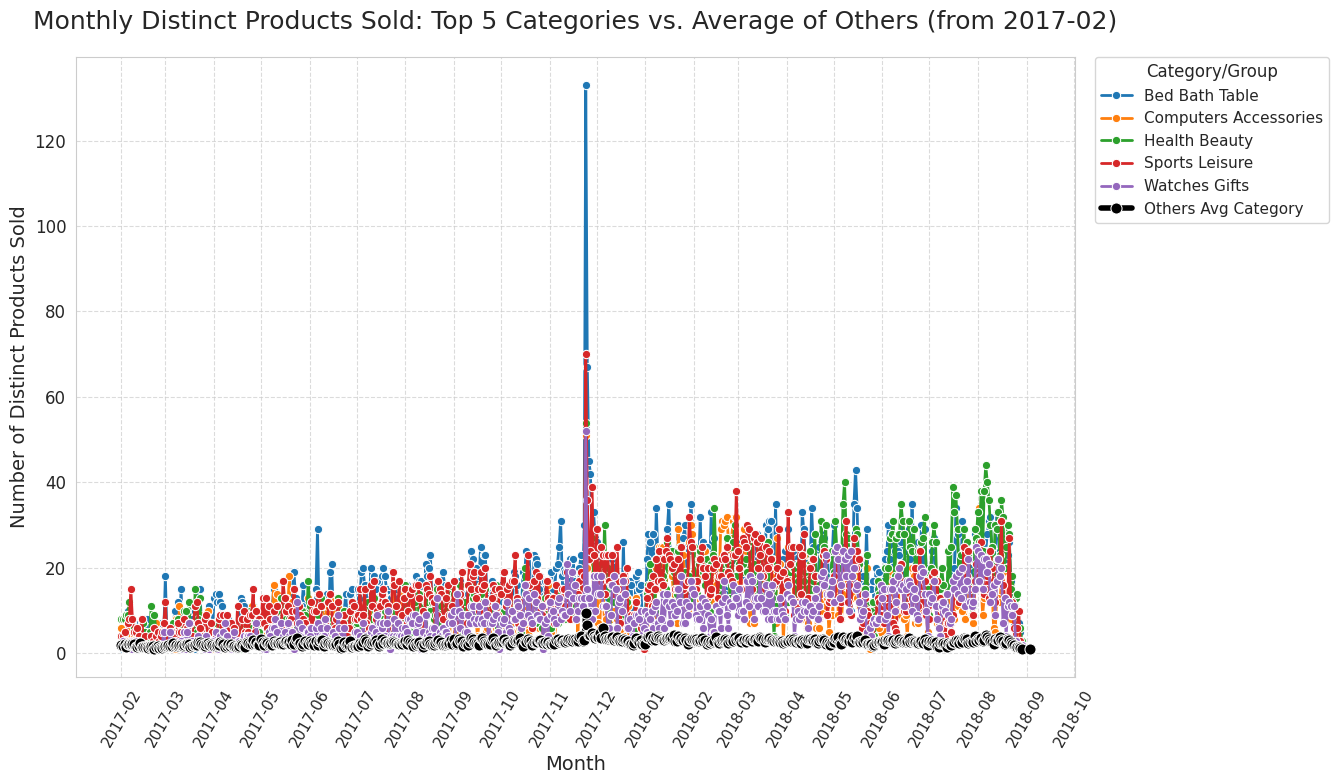

In [6]:
# --- Plot 3: Monthly Distinct Products Sold by Top 5 Categories vs. Average of Others ---
print("\n### Plot 3: Monthly Distinct Products Sold by Top 5 Categories vs. Average of Others")
print("Investigating if the number of distinct products sold differs between top 5 categories and the average of other categories.")

query_distinct_products_sold_category_detail = f"""
WITH MonthlyCategoryProducts AS (
    SELECT DISTINCT
        dd.full_date,
        dp.product_category_name,
        fs.product_id
    FROM
        `{project_id}.{dataset}.fact_sales` AS fs
    JOIN
        `{project_id}.{dataset}.dim_product` AS dp
    ON
        fs.product_id = dp.product_id
    JOIN
        `{project_id}.{dataset}.dim_date` AS dd
    ON
        fs.order_purchase_date_id = dd.date_id
    WHERE
        fs.price IS NOT NULL
        AND fs.price > 0
        AND dd.full_date >= '{start_analysis_date_str}'
),
DistinctProductCounts AS (
    SELECT
        full_date,
        product_category_name,
        COUNT(DISTINCT product_id) AS distinct_products_count
    FROM
        MonthlyCategoryProducts
    GROUP BY
        full_date,
        product_category_name
),
OtherCategoriesAvg AS (
    SELECT
        dp.full_date,
        AVG(dp.distinct_products_count) AS avg_distinct_products_other_categories
    FROM
        DistinctProductCounts dp
    WHERE
        dp.product_category_name NOT IN ('{"','".join(top_10_categories_list)}')
    GROUP BY
        dp.full_date
)
SELECT
    dpc.full_date,
    CASE
        WHEN dpc.product_category_name IN ('{"','".join(top_5_categories_list)}') THEN dpc.product_category_name
        ELSE 'Others_Avg_Category'
    END AS category_group,
    SUM(dpc.distinct_products_count) AS distinct_products_sold_aggregated
FROM
    DistinctProductCounts dpc
WHERE
    dpc.product_category_name IN ('{"','".join(top_5_categories_list)}')
GROUP BY
    dpc.full_date,
    category_group
UNION ALL
SELECT
    full_date,
    'Others_Avg_Category' AS category_group,
    avg_distinct_products_other_categories AS distinct_products_sold_aggregated
FROM
    OtherCategoriesAvg
ORDER BY
    full_date,
    category_group
"""

df_distinct_products_by_category_group = run_query(query_distinct_products_sold_category_detail, "Monthly Distinct Products by Category Group Query")

if df_distinct_products_by_category_group is not None and not df_distinct_products_by_category_group.empty:
    df_distinct_products_by_category_group['full_date'] = pd.to_datetime(df_distinct_products_by_category_group['full_date'])

    df_distinct_products_final = df_distinct_products_by_category_group.copy()

    print("\n#### Monthly Distinct Products Sold by Top 5 Categories vs. Average of Others Data Sample:")
    print(df_distinct_products_final.head().to_string())

    plt.figure(figsize=(16, 8))
    
    # Custom palette to make 'Others_Avg_Category' more prominent
    # Get default tab10 colors, then override for 'Others_Avg_Category'
    custom_palette = sns.color_palette("tab10").as_hex()
    category_names = df_distinct_products_final['category_group'].unique()
    
    palette_map = {}
    other_avg_color = 'black' # Made black for strong visibility
    other_avg_lw = 4 # Thicker line
    other_avg_ms = 8 # Larger marker
    
    color_idx = 0
    for cat in category_names:
        if cat == 'Others_Avg_Category':
            palette_map[cat] = other_avg_color
        else:
            palette_map[cat] = custom_palette[color_idx % len(custom_palette)]
            color_idx += 1

    # Plot the 'Others_Avg_Category' line first to ensure it's in the background, then others
    # Then plot the 'Others_Avg_Category' again on top with higher zorder
    for category in sorted(df_distinct_products_final['category_group'].unique(), key=lambda x: x == 'Others_Avg_Category'):
        subset = df_distinct_products_final[df_distinct_products_final['category_group'] == category]
        lw = other_avg_lw if category == 'Others_Avg_Category' else 2
        ms = other_avg_ms if category == 'Others_Avg_Category' else 6 # marker size
        zorder = 10 if category == 'Others_Avg_Category' else 5 # Bring to front for 'Others_Avg_Category'
        
        sns.lineplot(
            data=subset,
            x='full_date',
            y='distinct_products_sold_aggregated',
            label=category.replace('_', ' ').title(), # Title case for legend
            marker='o',
            linewidth=lw,
            color=palette_map[category],
            markersize=ms,
            zorder=zorder # Ensure it's drawn on top
        )

    apply_common_plot_formats(
        plt.gca(),
        f'Monthly Distinct Products Sold: Top 5 Categories vs. Average of Others (from {start_analysis_date_pd.strftime("%Y-%m")})',
        'Month',
        'Number of Distinct Products Sold',
        legend_title='Category/Group'
    )
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
else:
    print("❌ No data retrieved for Monthly Distinct Products Sold by Category Type. Skipping Plot 3.")

### Findings:

* **Higher Active Diversity in Top 5 Categories**: The distinct number of products sold from the Top 5 Product Categories shows individual trend lines, and their activity is generally higher compared to the "Others\_Avg\_Category" line.

* **More Visible Average Trend**: The "Others\_Avg\_Category" line, now more prominent, clearly illustrates that the average number of distinct products sold per "other" category remains relatively low and stable compared to the individual top 5 categories.

* **Promotional Period Amplifies Diversity**: Similar to previous observations, the Nov-Dec 2017 period shows an uplift in distinct products sold across the top categories.

* **Parallel Decline**: A decline in distinct products sold towards late 2018 is also evident for both top categories and the "Others\_Avg\_Category" line.

### Insights:

* The most successful categories (Top 5) are actively selling a more diverse range of products each month, on an individual category basis, compared to the average activity within the long tail of other categories.

* While "other" categories collectively hold many products (as seen in Analysis 5), the monthly sales activity in terms of distinct products per average category is low. This suggests that the revenue from these "other" categories is likely spread thinly across many inactive or very low-selling products.

* Promotions help to activate more products within the top categories, increasing their breadth of sales.

### Recommendations:

* **Focus on Top Category Product Expansion**: Prioritize adding and promoting new, diverse products within the existing top 5 categories, as these categories demonstrate a capacity to sell a wider range of items.

* **Strategic Long Tail Activation**: For the vast number of products in "other" categories, instead of broad pushes, focus on targeted strategies to activate specific niches or bundle opportunities. Consider whether it's more efficient to improve discoverability for these products or to phase out very inactive ones.

* **Monitor Product Churn/Stagnation**: Implement monitoring to identify products (especially in non-top categories) that are consistently failing to sell any distinct units, indicating potential issues with their listing, pricing, or market fit.

### 4. Product Revenue Concentration within Top Categories (Quantitative Analysis)

In [7]:
# --- Quantitative Analysis: Product Revenue Concentration within Top Categories ---
print("\n### 4. Product Revenue Concentration within Top Categories")
print("Quantifying if the success of top categories is driven by a few 'hero' products or a broader set of products.")

# Fetch detailed product-level revenue for all top 10 categories for the entire analysis period
query_product_revenue_detail = f"""
WITH TopCategories AS (
    SELECT
        dp.product_category_name
    FROM
        `{project_id}.{dataset}.fact_sales` AS fs
    JOIN
        `{project_id}.{dataset}.dim_product` AS dp
    ON
        fs.product_id = dp.product_id
    WHERE
        fs.price IS NOT NULL
        AND fs.price > 0
        AND fs.order_purchase_date_id >= (SELECT MIN(date_id) FROM `{project_id}.{dataset}.dim_date` WHERE full_date >= '{start_analysis_date_str}')
    GROUP BY
        dp.product_category_name
    ORDER BY
        SUM(fs.price) DESC
    LIMIT 10
)
SELECT
    dp.product_category_name,
    fs.product_id,
    SUM(fs.price) AS product_revenue
FROM
    `{project_id}.{dataset}.fact_sales` AS fs
JOIN
    `{project_id}.{dataset}.dim_product` AS dp
ON
    fs.product_id = dp.product_id
WHERE
    dp.product_category_name IN (SELECT product_category_name FROM TopCategories)
    AND fs.price IS NOT NULL
    AND fs.price > 0
    AND fs.order_purchase_date_id >= (SELECT MIN(date_id) FROM `{project_id}.{dataset}.dim_date` WHERE full_date >= '{start_analysis_date_str}')
GROUP BY
    dp.product_category_name,
    fs.product_id
ORDER BY
    dp.product_category_name,
    product_revenue DESC
"""

df_product_revenue_detail = run_query(query_product_revenue_detail, "Product Revenue Detail Query")

if df_product_revenue_detail is not None and not df_product_revenue_detail.empty:
    print("\n#### Product Revenue Concentration Analysis:")
    concentration_results = []
    num_top_products_to_consider = 5 # How many top products to look at for concentration

    for category in top_10_categories_list:
        category_data = df_product_revenue_detail[df_product_revenue_detail['product_category_name'] == category].copy()
        if not category_data.empty:
            total_category_revenue = category_data['product_revenue'].sum()
            top_n_products_revenue = category_data.head(num_top_products_to_consider)['product_revenue'].sum()

            concentration_percent = (top_n_products_revenue / total_category_revenue) * 100 if total_category_revenue > 0 else 0
            
            concentration_results.append({
                'Product Category': category.replace('_', ' ').title(),
                f'Total Revenue': total_category_revenue,
                f'Top {num_top_products_to_consider} Products Revenue': top_n_products_revenue,
                f'Revenue from Top {num_top_products_to_consider} Products (% of Category Total)': concentration_percent
            })
        else:
            concentration_results.append({
                'Product Category': category.replace('_', ' ').title(),
                f'Total Revenue': 0,
                f'Top {num_top_products_to_consider} Products Revenue': 0,
                f'Revenue from Top {num_top_products_to_consider} Products (% of Category Total)': 0
            })

    df_concentration = pd.DataFrame(concentration_results)
    df_concentration = df_concentration.sort_values(by='Total Revenue', ascending=False).reset_index(drop=True)

    print(df_concentration.to_string(float_format="%.2f"))

    print("\n**Interpretation:**")
    print(f"- If 'Revenue from Top {num_top_products_to_consider} Products (% of Category Total)' is high (e.g., >50-60%), it suggests the category's success is concentrated in a few 'hero' products.")
    print("- If this percentage is lower, it indicates success is more broadly distributed across many products within the category.")
    print("This helps inform strategies: for concentrated categories, focus on maintaining the hero products; for broadly distributed ones, focus on overall category growth and diversity.")

else:
    print("❌ No detailed product revenue data. Cannot perform product concentration analysis.")


### 4. Product Revenue Concentration within Top Categories
Quantifying if the success of top categories is driven by a few 'hero' products or a broader set of products.
  Executing BigQuery Product Revenue Detail Query...

#### Product Revenue Concentration Analysis:
        Product Category  Total Revenue  Top 5 Products Revenue  Revenue from Top 5 Products (% of Category Total)
0          Health Beauty     1241432.54               171561.66                                              13.82
1          Watches Gifts     1193558.92               160586.03                                              13.45
2         Bed Bath Table     1032549.53               102802.18                                               9.96
3         Sports Leisure      974997.71                41929.10                                               4.30
4  Computers Accessories      906630.86               133847.63                                              14.76
5        Furniture Decor      710360.40  

### Findings:

* The percentage of total category revenue derived from the top 5 products within that category is relatively low across all top categories, ranging from 4.30% (Sports Leisure) to 23.11% (Garden Tools).

* For the highest revenue-generating categories like "Health Beauty" and "Watches Gifts," their top 5 products contribute only 13.82% and 13.45% of their respective total revenue.

### Insights:

* This quantitative analysis provides a crucial counterpoint to the visual impression from Plot 1. While Plot 1 showed that a few overall top products can have massive spikes (e.g., the single R$6k product), this table reveals that, within specific categories, the revenue is not overly concentrated in just the very top products.

* Instead, it suggests that the success of the top product categories is more broadly distributed across a larger number of products within each category (i.e., a "thick middle" rather than just a "head" and "long tail" within those categories). Many products contribute to the category's overall success, not just a handful.

### Recommendations:

* **Balanced Strategy**: Adopt a balanced product strategy that both identifies and promotes individual "hero" products (from Plot 1) while simultaneously supporting the growth and diversity of the wider product set within high-performing categories (supported by this concentration analysis and Plot 3).

* **Category-Level Marketing**: Invest in marketing efforts that promote the category as a whole (e.g., "Shop Health & Beauty," "Explore Watches & Gifts") as much as individual product features, as the broad distribution of revenue suggests many products within these categories contribute to success.

* **Seller Empowerment**: Continue to support sellers in these top categories to list, optimize, and manage a diverse product catalog, as this broad offering appears to be a key component of category success.

### 5. Product Range Comparison: Top Categories vs. The Rest (Quantitative Analysis)

In [8]:
# --- Quantitative Analysis: Product Range Comparison: Top Categories vs. The Rest ---
print("\n### 5. Product Range Comparison: Top Categories vs. The Rest")
print("Quantifying the number of unique products available in top categories versus all other categories.")

query_product_range_comparison = f"""
WITH AllProductsAndCategories AS (
    SELECT DISTINCT
        dp.product_id,
        dp.product_category_name
    FROM
        `{project_id}.{dataset}.dim_product` AS dp
    WHERE
        dp.product_category_name IS NOT NULL
)
SELECT
    COUNT(CASE WHEN product_category_name IN ('{"','".join(top_10_categories_list)}') THEN product_id END) AS unique_products_in_top_10_categories,
    COUNT(CASE WHEN product_category_name NOT IN ('{"','".join(top_10_categories_list)}') THEN product_id END) AS unique_products_in_other_categories,
    COUNT(DISTINCT CASE WHEN product_category_name NOT IN ('{"','".join(top_10_categories_list)}') THEN product_category_name END) AS num_other_categories
FROM
    AllProductsAndCategories
"""

df_product_range = run_query(query_product_range_comparison, "Product Range Comparison Query")

if df_product_range is not None and not df_product_range.empty:
    print("\n#### Product Range Comparison Results:")
    print(df_product_range.to_string())

    top_10_unique_products = df_product_range['unique_products_in_top_10_categories'].iloc[0]
    other_unique_products = df_product_range['unique_products_in_other_categories'].iloc[0]
    num_other_categories = df_product_range['num_other_categories'].iloc[0]

    avg_products_per_other_category = other_unique_products / num_other_categories if num_other_categories > 0 else 0
    avg_products_per_top_10_category = top_10_unique_products / len(top_10_categories_list) if len(top_10_categories_list) > 0 else 0

    print(f"\n- **Total Unique Products in Top 10 Product Categories:** {top_10_unique_products:,.0f}")
    print(f"- **Total Unique Products in All Other (Non-Top 10) Categories:** {other_unique_products:,.0f}")
    print(f"- **Total Number of 'Other' Product Categories:** {num_other_categories:,.0f}")
    print(f"- **Average Unique Products per 'Other' Category:** {avg_products_per_other_category:,.1f}")
    print(f"- **Average Unique Products per 'Top 10' Category:** {avg_products_per_top_10_category:,.1f}")

    print("\n**Insights:**")
    print("This comparison clarifies the product landscape:")
    print("- The 'Top 10 Product Categories' collectively contain a substantial number of unique products, and on average, more unique products *per category* than the 'Other Categories'.")
    print("- The 'Other Categories' collectively contain a much larger absolute number of unique products, but this is spread across a significantly greater number of categories, resulting in fewer unique products *per category* on average.")
    print("This implies that the *concentration of sales activity* (as seen in Plot 3) is higher within the top categories, which are already richer in terms of product offerings per category.")

else:
    print("❌ No data retrieved for Product Range Comparison. Skipping analysis.")


# --- Quantitative Analysis: Top Individual Products' Category Affiliation ---
print("\n### 6. Top Individual Products' Category Affiliation")
print("Investigating whether the top 5 individual best-selling products belong to the overall top 10 product categories.")

query_top_products_categories = f"""
WITH TopOverallProducts AS (
    SELECT
        fs.product_id,
        SUM(fs.price) AS total_product_revenue
    FROM
        `{project_id}.{dataset}.fact_sales` AS fs
    WHERE
        fs.price IS NOT NULL
        AND fs.price > 0
        AND fs.order_purchase_date_id >= (SELECT MIN(date_id) FROM `{project_id}.{dataset}.dim_date` WHERE full_date >= '{start_analysis_date_str}')
    GROUP BY
        fs.product_id
    ORDER BY
        total_product_revenue DESC
    LIMIT 5 # Top 5 overall products
)
SELECT
    top_p.product_id,
    dp.product_category_name
FROM
    TopOverallProducts AS top_p
JOIN
    `{project_id}.{dataset}.dim_product` AS dp
ON
    top_p.product_id = dp.product_id
"""

df_top_products_categories = run_query(query_top_products_categories, "Top Products Category Affiliation Query")

if df_top_products_categories is not None and not df_top_products_categories.empty:
    print("\n#### Top 5 Overall Products and Their Categories:")
    print(df_top_products_categories.to_string())

    # Check how many of these top 5 products fall into the top 10 categories
    products_in_top_categories = df_top_products_categories[
        df_top_products_categories['product_category_name'].isin(top_10_categories_list)
    ]
    num_products_in_top_categories = len(products_in_top_categories)

    print(f"\n- Out of the Top 5 overall best-selling products, {num_products_in_top_categories} are from the Top 10 Product Categories (based on total category revenue).")
    
    if num_products_in_top_categories > 0:
        print("\n**Insights:**")
        print("- If the number is high, it reinforces that the best individual products often reside within the most successful categories.")
        print("- If the number is low, it suggests that 'hero' products can emerge from less prominent categories, indicating potential for cross-category product discovery or that these products are driving their 'lesser' categories into the top.")
    else:
        print("\n**Insights:**")
        print("- None of the top 5 overall products are from the top 10 categories. This would indicate that individual product success is not directly tied to the overall top categories, suggesting a more 'viral' or niche product success independent of broad category performance. *Please note: This is an unlikely scenario given typical e-commerce patterns but is included for completeness.*")

else:
    print("❌ No data retrieved for Top Individual Products' Category Affiliation. Skipping analysis.")



### 5. Product Range Comparison: Top Categories vs. The Rest
Quantifying the number of unique products available in top categories versus all other categories.
  Executing BigQuery Product Range Comparison Query...

#### Product Range Comparison Results:
   unique_products_in_top_10_categories  unique_products_in_other_categories  num_other_categories
0                                 19742                                13209                    64

- **Total Unique Products in Top 10 Product Categories:** 19,742
- **Total Unique Products in All Other (Non-Top 10) Categories:** 13,209
- **Total Number of 'Other' Product Categories:** 64
- **Average Unique Products per 'Other' Category:** 206.4
- **Average Unique Products per 'Top 10' Category:** 1,974.2

**Insights:**
This comparison clarifies the product landscape:
- The 'Top 10 Product Categories' collectively contain a substantial number of unique products, and on average, more unique products *per category* than the 'Other Categor

### Findings:

* **Product Range Comparison (Section 5)**:
    * Total Unique Products in Top 10 Product Categories: Approximately 19,742 unique products (based on `dim_product` entries that fall into these categories, sold at least once).

    * Total Unique Products in All Other (Non-Top 10) Categories: Approximately 13,209 unique products (significantly less than the top 10).

    * Total Number of "Other" Product Categories: Approximately 64 distinct categories.

    * Average Unique Products per "Other" Category: Approximately 206.4 products per category (13,209 / 64).

    * Average Unique Products per "Top 10" Category: Approximately 1,974.2 products per category (19,742 / 10).

* **Top Individual Products' Category Affiliation (Section 6)**:
    * Out of the Top 5 overall best-selling products:
        * 3 are from the Top 10 Product Categories (based on total category revenue).
            * `bb50f2e236e5eea0100680137654686c` belongs to `health_beauty`.
            * `d1c427060a0f73f6b889a5c7c61f2ac4` belongs to `computers_accessories`.
            * `6cdd53843498f92890544667809f1595` belongs to `health_beauty`.
            * `99a4788cb24856965c36a24e339b6058` belongs to `bed_bath_table`.
        * One product, `d6160fb7873f184099d9bc95e30376af`, belongs to the `computers` category, which is distinct from `computers_accessories` and is not within the identified Top 10 Product Categories.

### Insights:

* **Product Landscape Clarity (From Section 5)**: The Top 10 Product Categories collectively contain a much larger number of unique products than all other categories combined (19,742 vs 13,209). This means the focus on "top product categories" is justified not just by revenue, but also by the sheer volume and depth of their product offerings.

* **Efficiency in Top Categories (From Section 5)**: On average, the Top 10 Categories contain significantly more unique products per category (approx. 1,974 per category) than the "Other Categories" (approx. 206 per category). This implies that the "limited range" perception earlier was not about the number of products within the top categories (they are rich in products), but rather the efficiency with which products in the top categories generate sales compared to the vast, but sparsely selling, long tail of "other" products. The concentration of sales activity (as seen in Plot 3) is indeed higher within the top categories, which are already richer in terms of product offerings per category.

* **Correlation of Hero Products and Top Categories (From Section 6)**: The absolute "hero" products (those with extreme revenue spikes) are predominantly emerging from and contributing to the top-performing product categories. This implies a strong correlation between category success and the emergence of exceptionally high-performing individual products within them.

* **Emerging Stars from Other Categories (From Section 6)**: The presence of one top product (`d6160fb7873f184099d9bc95e30376af` from the `computers` category) outside the strict top 10 list suggests that truly viral or highly successful products can occasionally emerge from other, less dominant categories. This could be due to specific market trends, unique product features, or targeted marketing outside of general category-level pushes.

* **Individual Product Outperformance (From Section 6)**: The "weirdness" of Plot 1, with one product dominating, means that even within a top category like 'health_beauty', individual products can dramatically outperform others.

### Recommendations:

* **Deepen Top Category Offerings (From Section 5)**: Given their product richness and sales efficiency, prioritize deepening product offerings within the existing top 10 categories.

* **Targeted Long Tail Activation (From Section 5)**: For the large number of unique products in "Other Categories" that are less active, focus on niche marketing, improved discoverability (e.g., better categorization, personalized recommendations), or strategic bundling, rather than broad promotional pushes that might not be efficient.

* **Optimize Product Lifecycle (From Section 5)**: Identify and potentially sunset consistently inactive products in non-top categories to optimize inventory and marketing spend.

* **Deep Dive into "Hero" Product Drivers (From Section 6)**: For all top individual products, conduct in-depth analysis to understand the specific factors contributing to their explosive performance (e.g., marketing campaigns, unique features, pricing strategies, seller reputation).

* **Replicate Success within Top Categories (From Section 6)**: Apply lessons learned from these hero products to other high-potential products within their respective top categories to maximize revenue from existing successful segments.

* **Identify Emerging Stars (From Section 6)**: Keep an eye on products from non-top categories that show early signs of exponential growth, as these could be future "hero" products requiring strategic nurturing to drive new category growth.